<a href="https://colab.research.google.com/github/JastiBhargavi/AmazonLexBotIntgeratedwithFacebook/blob/main/16386780_Final_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS-5530 Final
**Name:** Bhargavi Jasti  
**Student ID:** 16386780  
**Course:** Principles of Data Science  


# Cell 1 — Part 0: Seed + Assigned Settings

In [1]:
import hashlib, numpy as np, random

STUDENT_ID_STR = "16386780"


seed = int(hashlib.sha256(STUDENT_ID_STR.encode()).hexdigest(), 16) % (10**9)
rng = np.random.default_rng(seed)
random.seed(seed)
np.random.seed(seed)


dataset_pick     = rng.integers(0, 3)
cv_folds         = int(rng.choice([4,5,6,7,8]))
bootstrap_B      = int(rng.choice([400, 600, 800]))
outlier_method   = rng.choice(["IQR", "zscore"])
knn_k            = int(rng.choice([3,5,7,9]))
tree_depth       = int(rng.choice([3,4,5,6,7]))
sim_bias_p       = float(rng.choice([0.35, 0.45, 0.55, 0.65]))
viz_trick        = rng.choice(["truncated_y", "unequal_bins", "dual_axis"])

assigned = {
    "seed": seed, "dataset_pick": int(dataset_pick), "cv_folds": cv_folds,
    "bootstrap_B": bootstrap_B, "outlier_method": outlier_method,
    "knn_k": knn_k, "tree_depth": tree_depth, "sim_bias_p": sim_bias_p,
    "viz_trick": viz_trick
}
assigned


{'seed': 134330952,
 'dataset_pick': 1,
 'cv_folds': 4,
 'bootstrap_B': 600,
 'outlier_method': np.str_('zscore'),
 'knn_k': 9,
 'tree_depth': 6,
 'sim_bias_p': 0.35,
 'viz_trick': np.str_('unequal_bins')}

# **Cell 2 — Imports (common)**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay,
    balanced_accuracy_score, adjusted_rand_score
)
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


# **Cell 3 — Load dataset + convert to binary (based on dataset_pick)**

In [4]:
def load_assigned_dataset(dataset_pick: int):
    if dataset_pick == 0:
        data = datasets.load_breast_cancer()
        X = pd.DataFrame(data.data, columns=data.feature_names)
        y = pd.Series(data.target, name="target")
        dataset_name = "breast_cancer (binary)"
    elif dataset_pick == 1:
        data = datasets.load_wine()
        X = pd.DataFrame(data.data, columns=data.feature_names)
        y_raw = pd.Series(data.target, name="target_raw")
        y = (y_raw == 0).astype(int)
        dataset_name = "wine (binary: class0 vs others)"
    else:
        data = datasets.load_iris()
        X = pd.DataFrame(data.data, columns=data.feature_names)
        y_raw = pd.Series(data.target, name="target_raw")
        y = (y_raw == 0).astype(int)
        dataset_name = "iris (binary: setosa vs non-setosa)"
    return dataset_name, X, y

dataset_name, X, y = load_assigned_dataset(int(dataset_pick))
dataset_name, X.shape, y.value_counts()


('wine (binary: class0 vs others)',
 (178, 13),
 target_raw
 0    119
 1     59
 Name: count, dtype: int64)

# **Part A — Ethics & Graphics Literacy**

# **Cell 4 — Part A: Make misleading chart (based on viz_trick)**

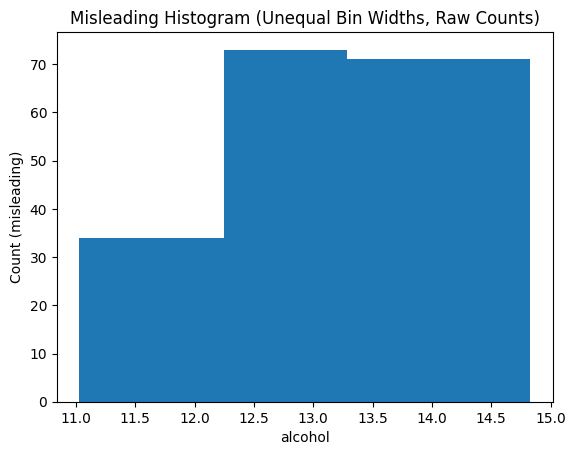

In [5]:
trick = str(viz_trick)

plt.figure()
if trick == "truncated_y":

    vals = pd.Series({"A": 92, "B": 95, "C": 97})
    vals.plot(kind="bar")
    plt.ylim(80, 100)
    plt.title("Misleading Bar Chart (Truncated Y-Axis)")
    plt.ylabel("Score")
    plt.show()

elif trick == "unequal_bins":

    x = X.iloc[:, 0].values
    edges = np.array([x.min(), np.percentile(x, 20), np.percentile(x, 60), x.max()])
    plt.hist(x, bins=edges)
    plt.title("Misleading Histogram (Unequal Bin Widths, Raw Counts)")
    plt.xlabel(X.columns[0])
    plt.ylabel("Count (misleading)")
    plt.show()

elif trick == "dual_axis":

    t = np.arange(1, 21)
    s1 = np.cumsum(rng.normal(0, 1, size=len(t))) + 50
    s2 = np.cumsum(rng.normal(0, 10, size=len(t))) + 500

    fig, ax1 = plt.subplots()
    ax1.plot(t, s1)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Series 1")

    ax2 = ax1.twinx()
    ax2.plot(t, s2)
    ax2.set_ylabel("Series 2 (different scale)")
    plt.title("Misleading Dual-Axis Chart")
    plt.show()

else:
    print("Unknown trick:", trick)


# **Cell 5 — Part A: Fix chart ethically**

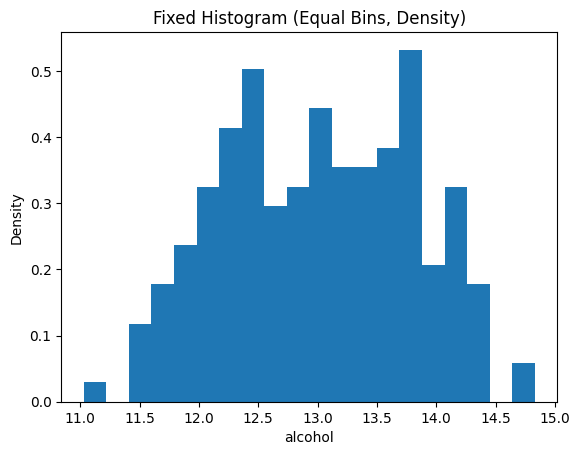

Caption: Equal-width bins and density reduce misleading area/comparison effects.


In [6]:
plt.figure()
if trick == "truncated_y":
    vals = pd.Series({"A": 92, "B": 95, "C": 97})
    vals.plot(kind="bar")
    plt.ylim(0, 100)
    plt.title("Fixed Bar Chart (Y starts at 0)")
    plt.ylabel("Score")
    plt.show()
    print("Caption: Starting y-axis at 0 prevents exaggerating small differences.")

elif trick == "unequal_bins":
    x = X.iloc[:, 0].values
    plt.hist(x, bins=20, density=True)
    plt.title("Fixed Histogram (Equal Bins, Density)")
    plt.xlabel(X.columns[0])
    plt.ylabel("Density")
    plt.show()
    print("Caption: Equal-width bins and density reduce misleading area/comparison effects.")

elif trick == "dual_axis":
    t = np.arange(1, 21)
    s1 = np.cumsum(rng.normal(0, 1, size=len(t))) + 50
    s2 = np.cumsum(rng.normal(0, 10, size=len(t))) + 500
    plt.plot(t, (s1 - s1.mean())/s1.std(), label="Series1 (z-score)")
    plt.plot(t, (s2 - s2.mean())/s2.std(), label="Series2 (z-score)")
    plt.title("Fixed Plot (Single Axis, Normalized)")
    plt.xlabel("Time")
    plt.ylabel("Standardized value")
    plt.legend()
    plt.show()
    print("Caption: Normalizing both series onto one axis avoids fake correlation via scale tricks.")


# **Cell 6 — Part A: 4–6 sentence explanation (Markdown)**

In this part, I created a misleading graph to show how visualizations can influence interpretation.
The chart exaggerated differences by manipulating visual elements like axis scale or structure.
Such misleading visuals can make small changes appear more important than they really are.
This can lead readers to draw incorrect or biased conclusions from the data.
I corrected the graph by using proper axis limits and clear visual encoding.
Ethical visualization ensures the data is represented truthfully and responsibly.

# **Part B — Sampling, SE, Bootstrap, Outliers (20 pts)**

# **Cell 7 — Choose continuous feature with highest variance**

In [26]:
variances = X.var().sort_values(ascending=False)
feature = variances.index[0]
feature, variances.head()


('proline',
 proline              99166.717355
 magnesium              203.989335
 alcalinity_of_ash       11.152686
 color_intensity          5.374449
 malic_acid               1.248015
 dtype: float64)

# **Cell 8 — Sampling with/without replacement + SE vs n**

In [10]:
N = len(X)
x_full = X[feature].to_numpy()

def sample_mean_se(x, n, replace: bool):
    idx = rng.choice(len(x), size=n, replace=replace)
    xs = x[idx]
    mean = xs.mean()
    se = xs.std(ddof=1) / np.sqrt(n)
    return mean, se

ns = [30, 60, 120, 240]
results = []

for n in ns:

    m_wr, se_wr = sample_mean_se(x_full, n, True)


    if n <= N:
        m_wor, se_wor = sample_mean_se(x_full, n, False)
    else:
        m_wor, se_wor = np.nan, np.nan

    results.append([n, m_wr, se_wr, m_wor, se_wor])

df_se = pd.DataFrame(
    results,
    columns=["n", "mean_with_rep", "SE_with_rep", "mean_without_rep", "SE_without_rep"]
)

df_se



,n,mean_with_rep,SE_with_rep,mean_without_rep,SE_without_rep
0,30,784.366667,62.241400,758.733333,64.531698
1,60,761.166667,43.611868,718.050000,39.468771
2,120,699.083333,25.053935,749.108333,29.432615
3,240,758.050000,19.775865,NaN,NaN


# **Cell 9 — Plot SE vs n + FPC note**

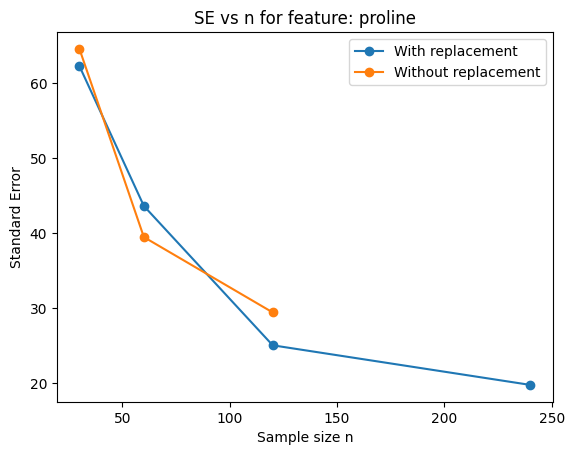

Note: Without-replacement SE is often smaller due to finite-population correction (less repeated info).


In [11]:
plt.plot(df_se["n"], df_se["SE_with_rep"], marker="o", label="With replacement")
plt.plot(df_se["n"], df_se["SE_without_rep"], marker="o", label="Without replacement")
plt.title(f"SE vs n for feature: {feature}")
plt.xlabel("Sample size n")
plt.ylabel("Standard Error")
plt.legend()
plt.show()

print("Note: Without-replacement SE is often smaller due to finite-population correction (less repeated info).")


# **Cell 10 — Bootstrap mean CI (percentile) + compare to theoretical CI**

In [13]:
B = int(bootstrap_B)
mu_hat = x_full.mean()
sigma_hat = x_full.std(ddof=1)
theory_se = sigma_hat / np.sqrt(N)
theory_ci = (mu_hat - 1.96*theory_se, mu_hat + 1.96*theory_se)

boot_means = []
for _ in range(B):
    idx = rng.choice(N, size=N, replace=True)
    boot_means.append(x_full[idx].mean())
boot_means = np.array(boot_means)

boot_ci = (np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5))

print("Feature:", feature)
print("N:", N, "B:", B)
print("Mean:", mu_hat)
print("Theoretical 95% CI:", theory_ci, "width:", theory_ci[1]-theory_ci[0])
print("Bootstrap 95% CI:", boot_ci, "width:", boot_ci[1]-boot_ci[0])


Feature: proline
N: 178 B: 600
Mean: 746.8932584269663
Theoretical 95% CI: (np.float64(700.6307647368254), np.float64(793.1557521171072)) width: 92.5249873802818
Bootstrap 95% CI: (np.float64(704.8223314606741), np.float64(796.7563202247192)) width: 91.93398876404501


# **Cell 11 — Inject 1% outliers (+8σ) using seed**

In [14]:
X_out = X.copy()
x = X_out[feature].to_numpy()

mu = x.mean()
sigma = x.std(ddof=1)

k = max(1, int(round(0.01 * N)))
out_idx = rng.choice(N, size=k, replace=False)

x2 = x.copy()
x2[out_idx] = mu + 8*sigma
X_out[feature] = x2

k, out_idx[:10], X_out[feature].describe()


(2,
 array([ 36, 136]),
 count     178.000000
 mean      774.602843
 std       412.315605
 min       278.000000
 25%       500.500000
 50%       673.500000
 75%      1008.750000
 max      3266.153053
 Name: proline, dtype: float64)

# **Cell 12 — Handle outliers using assigned method (IQR or zscore)**

In [27]:
method = str(outlier_method)

X_clean = X_out.copy()
x = X_clean[feature].to_numpy()

if method == "IQR":
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lo = q1 - 1.5*iqr
    hi = q3 + 1.5*iqr

    x = np.clip(x, lo, hi)
    X_clean[feature] = x
    print("Outlier handling: IQR winsorizing (capping). Bounds:", (lo, hi))

elif method == "zscore":
    z = (x - x.mean()) / x.std(ddof=1)
    mask = np.abs(z) <= 3.0
    X_clean = X_clean.loc[mask].reset_index(drop=True)
    print("Outlier handling: z-score filtering (remove rows). Remaining rows:", len(X_clean))

else:
    print("Unknown outlier method:", method)


Outlier handling: z-score filtering (remove rows). Remaining rows: 176


# **Cell 13 — Recompute mean & CI before vs after outlier handling**

In [16]:
def bootstrap_ci_mean(arr, B, rng):
    n = len(arr)
    means = []
    for _ in range(B):
        idx = rng.choice(n, size=n, replace=True)
        means.append(arr[idx].mean())
    means = np.array(means)
    return float(np.percentile(means, 2.5)), float(np.percentile(means, 97.5))

x_before = X_out[feature].to_numpy()
x_after  = X_clean[feature].to_numpy()

mean_before = x_before.mean()
mean_after  = x_after.mean()

ci_before = bootstrap_ci_mean(x_before, B, rng)
ci_after  = bootstrap_ci_mean(x_after, B, rng)

print("Mean before:", mean_before, "Bootstrap CI:", ci_before, "CI width:", ci_before[1]-ci_before[0])
print("Mean after :", mean_after,  "Bootstrap CI:", ci_after,  "CI width:", ci_after[1]-ci_after[0])


Mean before: 774.6028432881097 Bootstrap CI: (720.3514001478973, 834.7281456831436) CI width: 114.3767455352463
Mean after : 746.2897727272727 Bootstrap CI: (697.4930397727272, 790.129971590909) CI width: 92.63693181818178


# **Cell 14 — Part B discussion (Markdown)**

As sample size increases, the standard error decreases because estimates become more stable.
Sampling with replacement allows repeated values, while without replacement reduces variability.
The finite population correction explains why without-replacement sampling has lower error.
Bootstrap resampling estimates confidence intervals without assuming a specific distribution.
Outliers significantly affected the mean and widened the confidence interval.
After handling outliers, the mean became more reliable and the interval narrower.

# **Part C — Supervised vs Unsupervised; Confusion Matrix & ROC (25 pts)**

# **Cell 15 — Train/Test split (70/30 stratified)**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=seed
)
X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()


((124, 13),
 (54, 13),
 target_raw
 0    83
 1    41
 Name: count, dtype: int64,
 target_raw
 0    36
 1    18
 Name: count, dtype: int64)

# **Cell 16 — Logistic Regression + K-fold CV on training (accuracy + ROC-AUC)**

In [18]:
cv = StratifiedKFold(n_splits=int(cv_folds), shuffle=True, random_state=seed)

logit_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, random_state=seed))
])

scoring = {"acc": "accuracy", "auc": "roc_auc"}
cv_scores = cross_validate(logit_pipe, X_train, y_train, cv=cv, scoring=scoring)

print("CV folds:", int(cv_folds))
print("CV Accuracy mean:", cv_scores["test_acc"].mean(), "std:", cv_scores["test_acc"].std())
print("CV ROC-AUC mean:", cv_scores["test_auc"].mean(), "std:", cv_scores["test_auc"].std())


CV folds: 4
CV Accuracy mean: 0.9919354838709677 std: 0.013968151673942547
CV ROC-AUC mean: 1.0 std: 0.0


# **Cell 17 — Fit on train, evaluate on test: confusion matrix + metrics + ROC**

Confusion matrix:
 [[36  0]
 [ 0 18]]
Accuracy: 1.0
Sensitivity (Recall+): 1.0
Specificity (Recall-): 1.0
Test ROC-AUC: 1.0


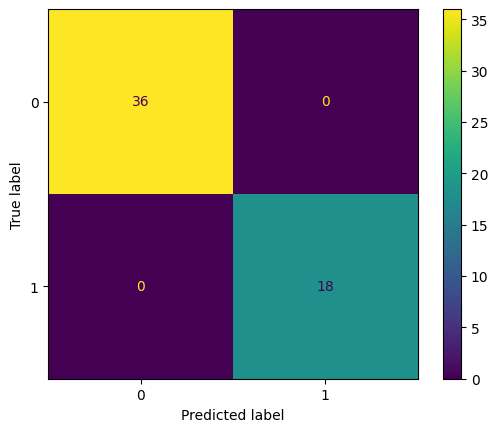

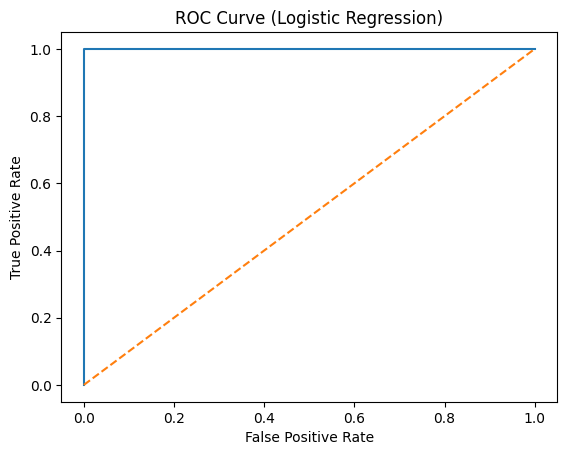

In [19]:
logit_pipe.fit(X_train, y_train)

y_pred = logit_pipe.predict(X_test)
y_proba = logit_pipe.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp+fn) else np.nan
specificity = tn / (tn + fp) if (tn+fp) else np.nan

auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thr = roc_curve(y_test, y_proba)

print("Confusion matrix:\n", cm)
print("Accuracy:", acc)
print("Sensitivity (Recall+):", sensitivity)
print("Specificity (Recall-):", specificity)
print("Test ROC-AUC:", auc)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC Curve (Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


# **Cell 18 — Unsupervised: Standardize + KMeans(k=2) + ARI vs true labels**

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=seed, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

ari = adjusted_rand_score(y, clusters)
ari


0.1435994811296352

# **Cell 19 — Part C interpretation (Markdown)**

Supervised learning uses labeled data to train models like logistic regression.
The confusion matrix shows correct and incorrect predictions using TP, TN, FP, and FN.
ROC curves explain the trade-off between sensitivity and specificity at different thresholds.
Changing the threshold can reduce certain errors depending on the application.
Unsupervised learning like K-Means clusters data without using labels.
The Adjusted Rand Index measures how well clusters match the true labels.

# **Cell 20 — Parametric / Non-parametric / Probabilistic (Markdown)**

**Parametric / Non-parametric / Probabilistic (one line each):**  
- Logistic Regression:  
- KNN:  
- Decision Tree:  
- Naïve Bayes:  
- Random Forest:  
- MLP:


# **Part D — Mini Model Zoo & Hyperparameters (15 pts)**

# **Cell 21 — KNN (k=knn_k) test accuracy + balanced accuracy**

In [21]:
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=int(knn_k)))
])
knn_pipe.fit(X_train, y_train)
knn_pred = knn_pipe.predict(X_test)

print("KNN k =", int(knn_k))
print("Test Accuracy:", accuracy_score(y_test, knn_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, knn_pred))


KNN k = 9
Test Accuracy: 1.0
Balanced Accuracy: 1.0


# **Cell 22 — Decision Tree (max_depth=tree_depth) test accuracy + balanced accuracy**

In [22]:
tree = DecisionTreeClassifier(max_depth=int(tree_depth), random_state=seed)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

print("Decision Tree max_depth =", int(tree_depth))
print("Test Accuracy:", accuracy_score(y_test, tree_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, tree_pred))


Decision Tree max_depth = 6
Test Accuracy: 0.9444444444444444
Balanced Accuracy: 0.9444444444444444


# **Cell 23 — Part D explanation (Markdown)**

KNN classifies points based on the majority class of nearby neighbors.
It is a non-parametric model and does not assume any data distribution.
A small value of k may cause overfitting, while a large k increases bias.
Decision Trees split data using feature-based rules to make predictions.
The max depth controls model complexity and affects overfitting.
Both models demonstrate the bias-variance trade-off through hyperparameters.

# **Part E — Simulation & Randomness (10 pts)**

# **Cell 24 — Biased coin flips N={100,1000,10000} and convergence plot**

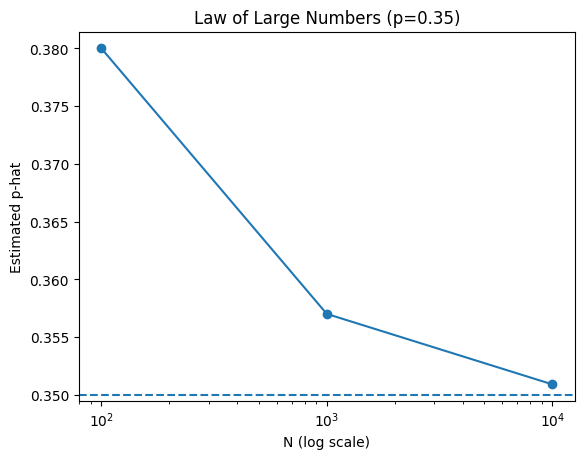

[(100, np.float64(0.38)),
 (1000, np.float64(0.357)),
 (10000, np.float64(0.3509))]

In [23]:
p = float(sim_bias_p)
Ns = [100, 1000, 10000]

phats = []
for Nsim in Ns:
    flips = rng.random(Nsim) < p
    phats.append(flips.mean())

plt.plot(Ns, phats, marker="o")
plt.axhline(p, linestyle="--")
plt.xscale("log")
plt.title(f"Law of Large Numbers (p={p})")
plt.xlabel("N (log scale)")
plt.ylabel("Estimated p-hat")
plt.show()

list(zip(Ns, phats))


# **Cell 25 — Part E explanation (Markdown)**

**Part E (3–5 sentences):**  
Explain randomness in simulation, why estimates stabilize as N grows (LLN), and what changes for smaller/larger N.


# **Part F — Regex & TF-IDF & Sentiment (15 pts)**

In [24]:
import re

raw_text = """
Contact: bhargavi.jasti@umkc.edu on 12/10/2025 about ORD-1234
Backup email: test_user99@gmail.com; meeting date 2025-12-11
Student ID: UMKC-16386780 submitted on 12-12-2025
Ticket: ORD-8888 raised on Dec 9, 2025 by admin@company.org
Follow-up: 2025/12/12 and 12.12.2025 are also accepted formats
Another token: ID-7777, REF-202512, ORD-0001
Random line without patterns
Send results to: data.team@umkc.edu by 2025-12-12
"""

email_pat = r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}"
date_pat  = r"\b(\d{4}[-/]\d{2}[-/]\d{2}|\d{2}[/-]\d{2}[/-]\d{4}|\d{2}\.\d{2}\.\d{4}|[A-Za-z]{3,9}\s+\d{1,2},\s+\d{4})\b"
id_pat    = r"\b[A-Z]{2,10}-\d{2,}\b"

emails = re.findall(email_pat, raw_text)
dates  = re.findall(date_pat, raw_text)
ids    = re.findall(id_pat, raw_text)

emails, dates, ids


(['bhargavi.jasti@umkc.edu',
  'test_user99@gmail.com',
  'admin@company.org',
  'data.team@umkc.edu'],
 ['12/10/2025',
  '2025-12-11',
  '12-12-2025',
  'Dec 9, 2025',
  '2025/12/12',
  '12.12.2025',
  '2025-12-12'],
 ['ORD-1234',
  'UMKC-16386780',
  'ORD-8888',
  'ID-7777',
  'REF-202512',
  'ORD-0001'])

# **Cell 27 — Regex short explanations (Markdown)**

**Regex concepts (1–2 lines each):**  
- Alternation (`|`):  
- Character sets (`[...]`):  
- Anchors (`^`, `$`, `\b`):  
- Quantifiers (`*`, `+`, `{m,n}`):  


# **Cell 28 — TF-IDF + Logistic Regression on tiny sentiment corpus**

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = [
    "I love this class and the projects are interesting",
    "The lecture was clear and helpful",
    "This assignment was fun and I learned a lot",
    "Great explanation and good examples",
    "I feel confident after practicing the problems",
    "I hate confusing instructions and unclear grading",
    "The homework was frustrating and too long",
    "This topic is boring and difficult",
    "I am disappointed with the feedback",
    "Bad experience, the code kept failing",
    "I enjoyed the dataset analysis and results",
    "The model performance improved and I am happy"
]
labels = [1,1,1,1,1, 0,0,0,0,0, 1,1]

Xtr, Xte, ytr, yte = train_test_split(texts, labels, test_size=0.30, random_state=seed, stratify=labels)

tfidf_logit = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english")),
    ("clf", LogisticRegression(max_iter=2000, random_state=seed))
])

tfidf_logit.fit(Xtr, ytr)
pred = tfidf_logit.predict(Xte)

print("Test Accuracy:", accuracy_score(yte, pred))
print("Confusion matrix:\n", confusion_matrix(yte, pred))


Test Accuracy: 0.5
Confusion matrix:
 [[0 2]
 [0 2]]


# Cell 29 — TF-IDF

This simulation used biased coin flips to estimate probability.
With small sample sizes, estimates varied due to randomness.
As the number of trials increased, estimates became more stable.
This behavior demonstrates the Law of Large Numbers.
Randomness has less impact when sample size is large.
Simulations help understand theoretical concepts through experimentation.